# Towards an energy budget

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as itgr
from matplotlib.gridspec import GridSpec

import convenience_funcs as cfs
import load_data
import munch
import utils

matplotlib.rc("font", size=7)
matplotlib.rc("axes", titlepad=1)

save_figs = True

pdd = "../data"
fsd = "../figures"
data_in = pdd

moorings = load_data.load_my_data()
ca, cw = load_data.load_my_data_alt()
ca = munch.munchify(ca)
cw = munch.munchify(cw)

moorings = [munch.munchify(m) for m in moorings]

cc, nw, ne, se, sw = moorings

VMP = utils.loadmat(os.path.join(data_in, "VMP.mat"))
VMP = munch.munchify(VMP)

## Total flux full time series cumulative

Vertical transfer at 566 m is -7.318e-10 +/- 5.908e-10 W/kg
Vertical transfer at 1243 m is -1.012e-09 +/- 5.251e-10 W/kg
Vertical transfer at 2084 m is 4.341e-11 +/- 1.599e-10 W/kg
Vertical transfer at 3388 m is -1.786e-09 +/- 7.900e-10 W/kg


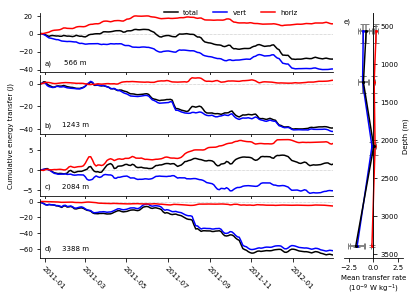

In [4]:
rho0 = 1025.0
m = ca
#####################################

fig = plt.figure(figsize=(6.5, 4.5))
gs = GridSpec(ca.N_levels * 2, 2, width_ratios=[5, 1], hspace=0.1, wspace=0.06)
axs = [plt.subplot(gs[i * 2 : (i + 1) * 2, 0]) for i in range(ca.N_levels)]
axp = plt.subplot(gs[:, 1])
axp.yaxis.set_ticks_position("right")
axp.yaxis.set_label_position("right")

for ax in axs[:-1]:
    ax.set_xticklabels([])

# Simplify plots
for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axp.spines["top"].set_visible(False)
axp.spines["left"].set_visible(False)
axp.spines["right"].set_position("zero")

F_err_tot = 1.96 * utils.emean(ca.errF_total)

for lev in range(ca.N_levels):
    t = (ca.t[:, lev] - ca.t[0, lev]) * 86400
    #     dt = t[1] - t[0]
    tdt = ca.tdt[:, lev]

    axs[lev].set_xlim(tdt[0], tdt[-1])
    axs[lev].axhline(0, color="k", lw=0.5, ls=":", alpha=0.5)

    axs[lev].plot(
        tdt,
        rho0 * itgr.cumtrapz(ca.F_total[:, lev], t, initial=0),
        label="total",
        color="k",
    )
    axs[lev].plot(
        tdt,
        rho0 * itgr.cumtrapz(ca.F_vert[:, lev], t, initial=0),
        label="vert",
        color="b",
    )
    axs[lev].plot(
        tdt,
        rho0 * itgr.cumtrapz(ca.F_horiz[:, lev], t, initial=0),
        label="horiz",
        color="r",
    )

    print(
        "Vertical transfer at {:1.0f} m is {:1.3e} +/- {:1.3e} W/kg"
        "".format(-m.z[:, lev].mean(), ca.F_total[:, lev].mean(), F_err_tot[lev])
    )

    axs[lev].annotate(
        "{:1.0f} m".format(-ca.z[:, lev].mean()),
        xy=(0.12, 0.16),
        xycoords="axes fraction",
        ha="center",
        va="center",
    )

axs[0].legend(loc=3, ncol=3, bbox_to_anchor=(0.4, 0.85), frameon=False)

c = 1e9
F_vert_err = 1.96 * utils.emean(ca.errF_vert)
yerr = np.abs(np.percentile(-ca.z, [10, 90], axis=0) + ca.z.mean(axis=0))
axp.errorbar(
    c * ca.F_vert.mean(axis=0),
    -ca.z.mean(axis=0),
    xerr=c * F_vert_err,
    yerr=yerr,
    fmt="o-",
    capsize=3,
    color="b",
    ecolor="grey",
    markersize=2,
)
F_horiz_err = 1.96 * utils.emean(ca.errF_horiz)
axp.errorbar(
    c * ca.F_horiz.mean(axis=0),
    -ca.z.mean(axis=0),
    xerr=c * F_horiz_err,
    yerr=yerr,
    fmt="o-",
    capsize=3,
    color="r",
    ecolor="grey",
    markersize=2,
)
axp.errorbar(
    c * ca.F_total.mean(axis=0),
    -ca.z.mean(axis=0),
    xerr=c * F_err_tot,
    yerr=yerr,
    fmt="o-",
    capsize=3,
    color="k",
    ecolor="grey",
    markersize=2,
)
axp.set_xlim(-3, 3)
axp.axvline(0, color="k", linewidth=1, alpha=0.5)
axp.set_xlabel("Mean transfer rate\n($10^{-9}$ W kg$^{-1}$)")
axp.set_ylabel("Depth (m)")
axp.invert_yaxis()

cfs.ylabel("Cumulative energy transfer (J)", fig, axs[1], axs[2], -0.07)
# axs[2].set_ylabel("Vertical energy transfer rate ($10^{-9}$ W kg$^{-1}$)")
cfs.axes_labels(
    fig,
    axs,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="square", alpha=0.8),
    dx=0.01,
    dy=-0.16,
)
cfs.axes_labels(
    fig,
    axp,
    i0=4,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="square", alpha=0.8),
    dx=0.0,
    dy=-0.03,
)

plt.setp(
    axs[-1].xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor"
)

if save_figs:
    fig_name = "total_energy_flux_all_levels.pdf"
    fig.savefig(os.path.join(fsd, fig_name), dpi=300, bbox_inches="tight", pad_inches=0)
    fig_name = "total_energy_flux_all_levels.png"
    fig.savefig(os.path.join(fsd, fig_name), dpi=300, bbox_inches="tight", pad_inches=0)

plt.show()

## Depth integrated fluxes

zmin -3388 m
zmax -566 m
F_int = -2.188e-03 W/m^2
F_eff_int = -1.477e-03 W/m^2
F_horiz_int = 2.721e-04 W/m^2
F_vert_int = -2.460e-03 W/m^2
F_vert_eff_int = -1.749e-03 W/m^2
epsa_int = 1.360e-03 W/m^2
epsg_int = 4.673e-04 W/m^2
BBL = 2.696e-03 W/m^2


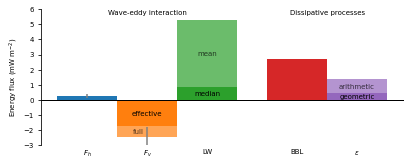

In [6]:
m = ca
g0 = 1025.0
Cd = 2e-3

z = m.z.mean(axis=0)
zmin = z[-1]
zmax = z[0]

print("zmin {:1.0f} m".format(zmin))
print("zmax {:1.0f} m".format(zmax))

use = (VMP.z[:, 0] > zmin) & (VMP.z[:, 0] < zmax)

zvmp = VMP.z[use, 0]
epsam = np.nanmean(VMP.eps[use, :], axis=1)
epsgm = cfs.nangmean(VMP.eps[use, :], axis=1)

F_total = m.F_vert.mean(axis=0) + m.F_horiz.mean(axis=0)
F_total_eff = m.F_vert_alt.mean(axis=0) + m.F_horiz.mean(axis=0)

# Cumulative integration.
F_int = -g0 * np.trapz(F_total, z)
F_eff_int = -g0 * np.trapz(F_total_eff, z)
F_horiz_int = -g0 * np.trapz(m.F_horiz.mean(axis=0), z)
F_vert_int = -g0 * np.trapz(m.F_vert.mean(axis=0), z)
F_vert_eff_int = -g0 * np.trapz(m.F_vert_alt.mean(axis=0), z)
epsa_int = -g0 * np.trapz(epsam, zvmp)
epsg_int = -g0 * np.trapz(epsgm, zvmp)

# Error on integrals.
Fhierr = 1.96 * g0 * utils.etrapz(utils.emean(m.errF_horiz, axis=0), z)
Fvierr = 1.96 * g0 * utils.etrapz(utils.emean(m.errF_vert, axis=0), z)

U = ((cc.u[:, -1] ** 2 + cc.v[:, -1] ** 2) ** 0.5).mean()
BBL = 2 * Cd * g0 * U ** 3

print("F_int = {:1.3e} W/m^2".format(F_int))
print("F_eff_int = {:1.3e} W/m^2".format(F_eff_int))
print("F_horiz_int = {:1.3e} W/m^2".format(F_horiz_int))
print("F_vert_int = {:1.3e} W/m^2".format(F_vert_int))
print("F_vert_eff_int = {:1.3e} W/m^2".format(F_vert_eff_int))
print("epsa_int = {:1.3e} W/m^2".format(epsa_int))
print("epsg_int = {:1.3e} W/m^2".format(epsg_int))
# print('BBL_lo = {:1.3e} W/m^2'.format(BBL_lo))
# print('BBL_hi = {:1.3e} W/m^2'.format(BBL_hi))
print("BBL = {:1.3e} W/m^2".format(BBL))

c = 1e3
width = 1
fig, ax = plt.subplots(1, 1, figsize=(6.5, 2.5))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.axhline(0, color="k", linewidth=1)
ax.tick_params(axis="x", which="both", length=0)
ax.set_ylim(-3, 6)

ax.bar(0, c * F_horiz_int, width, color="C0", yerr=c * Fhierr, ecolor="grey")

ax.bar(1, c * F_vert_int, width, color="C1", alpha=0.7, yerr=c * Fvierr, ecolor="grey")
ax.bar(1, c * F_vert_eff_int, width, color="C1")  # , yerr=c*Fvaierr, ecolor='grey')

ax.bar(2, 5.3, width, color="C2", alpha=0.7)  # Anual mean
ax.bar(2, 0.86, width, color="C2")  # Anual median

ax.bar(3.5, c * BBL, width, color="C3")

ax.bar(4.5, c * epsa_int, width, color="C4", alpha=0.7)
ax.bar(4.5, c * epsg_int, width, color="C4")

text_kwargs = {"ha": "center", "va": "center"}

ax.annotate("effective", (1, c * F_vert_eff_int / 2), **text_kwargs)
ax.annotate(
    "full",
    (0.85, c * (F_vert_eff_int + 0.5 * (F_vert_int - F_vert_eff_int))),
    **text_kwargs,
    alpha=0.7
)
ax.annotate("mean", (2, 0.86 + 0.5 * (5.3 - 0.86)), **text_kwargs, alpha=0.7)
ax.annotate("median", (2, 0.86 / 2), **text_kwargs)
# ax.annotate('eddies', (3.5, c*BBL_lo/2), **text_kwargs)
# ax.annotate('waves', (3.5, c*(BBL_lo + 0.5*BBL_hi)), **text_kwargs, alpha=0.7)
ax.annotate("geometric", (4.5, c * epsg_int / 2), **text_kwargs)
ax.annotate(
    "arithmetic",
    (4.5, c * (epsg_int + 0.5 * (epsa_int - epsg_int))),
    **text_kwargs,
    alpha=0.7
)

ax.annotate("Wave-eddy interaction", (1, 5.8), **text_kwargs)
ax.annotate("Dissipative processes", (4, 5.8), **text_kwargs)

# Annotate horizontal and vertical

ax.set_ylabel("Energy flux (mW m$^{-2}$)")
ax.set_xticks([0, 1, 2, 3.5, 4.5])
ax.set_xticklabels([r"$F_h$", r"$F_v$", "LW", "BBL", r"$\epsilon$"])

if save_figs:
    fig.savefig(
        os.path.join(fsd, "integrated_flux.pdf"),
        bbox_inches="tight",
        pad_inches=0,
        dpi=300,
    )
    fig.savefig(
        os.path.join(fsd, "integrated_flux.png"),
        bbox_inches="tight",
        pad_inches=0,
        dpi=300,
    )

### RMS shear and strain

In [10]:
m = ca

for lev in range(ca.N_levels):
    print("mean depth {:1.0f} m".format(-ca.z[:, lev].mean()))
    print("shear strain rate std {:1.1e} s-1".format(ca.sstrain[:, lev].std()))
    print("vertial shear std {:1.1e} s-1".format(ca.dudz[:, lev].std()))

mean depth 566 m
shear strain rate std 7.7e-06 s-1
vertial shear std 1.5e-04 s-1
mean depth 1243 m
shear strain rate std 6.0e-06 s-1
vertial shear std 1.5e-04 s-1
mean depth 2084 m
shear strain rate std 5.0e-06 s-1
vertial shear std 6.3e-05 s-1
mean depth 3388 m
shear strain rate std 5.7e-06 s-1
vertial shear std 9.7e-05 s-1
